In [1]:
import os
import re
import path
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [3]:
pwd = "../data/00_raw"
filenames = os.listdir(pwd)

PERSPECTIVE_CHAR_LIMIT = 3000
n_small_corpus = 0
n_curse_words = 0

for file in filenames:
    with open(os.path.join(pwd, file)) as f:
        content = f.read()
    
    if len(content) <= PERSPECTIVE_CHAR_LIMIT:
        n_small_corpus += 1
    
    n_curse_words += len(re.findall("\[ __ \]+", content))

In [4]:
n_files = len(filenames)

print("Basic Statistics")
print("----------------")
print(f"  - Percentage of data with less than 5000 characters is {n_small_corpus/n_files*100:0.2f}%")
print(f"  - Average number of curse words is {n_curse_words/n_files:0.2f} per file")

Basic Statistics
----------------
  - Percentage of data with less than 5000 characters is 6.62%
  - Average number of curse words is 0.78 per file


---

In [5]:
df_download_info = pd.read_csv("../data/download_descriptions.csv")

print("Basic Statistics")
print("----------------")
print(f"  - There are {df_download_info.movie.nunique()} different movies")

Basic Statistics
----------------
  - There are 50 different movies


---

In [6]:
pwd = "../data/03_scored/without_curse_words"
filenames = os.listdir(pwd)

print(f"  - There are {len(filenames)} different review videos")

  - There are 553 different review videos


---

### Corpus Size Distribution

In [7]:
pwd = "../data/01_preprocessed/without_curse_words"
filenames = os.listdir(pwd)

corpus_sizes = []
for file in filenames:
    with open(os.path.join(pwd, file)) as f:
        content = f.read()
    
    corpus_sizes.append(len(content))

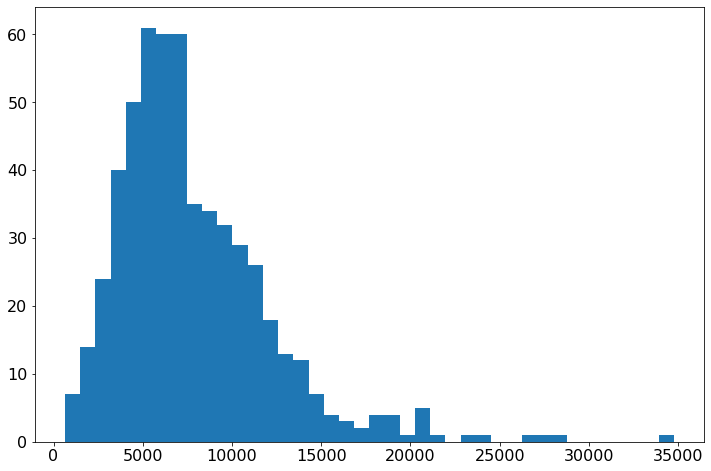

In [8]:
plt.subplots(figsize=(12,8))
plt.hist(corpus_sizes, bins=40)
plt.show()

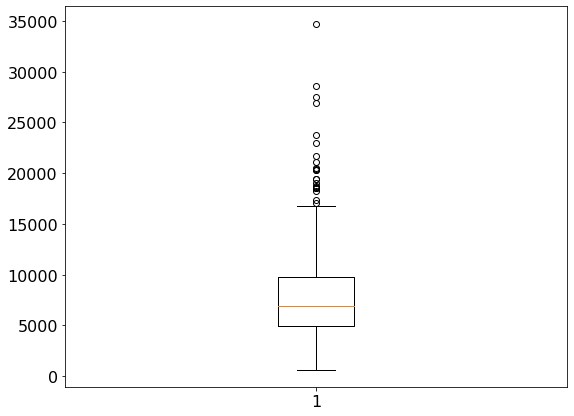

In [9]:
plt.subplots(figsize=(9,7))
plt.boxplot(corpus_sizes)
plt.show()

---

### Demographic Groups' Proportions

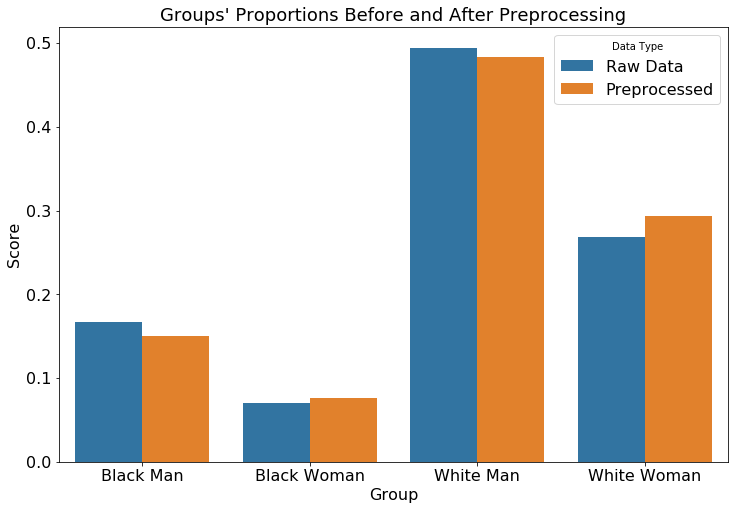

In [10]:
df_raw = pd.read_csv("../data/download_descriptions.csv")

pwd = "../data/01_preprocessed/without_curse_words"
filenames = os.listdir(pwd)

processed_proportions = {}
for group in df_raw.group.unique():
    for _, row in df_raw[df_raw.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]

        if video_id in filenames:  
            processed_proportions[group] = processed_proportions.get(group, 0) + 1/len(filenames)


raw_proportions = df_raw.groupby("group").movie.count()/df_raw.shape[0]

df1 = pd.DataFrame(raw_proportions.reset_index().values, columns=["Group", "Score"])
df1["Data Type"] = "Raw Data"

df2 = pd.DataFrame(processed_proportions.items(), columns=["Group", "Score"])
df2["Data Type"] = "Preprocessed"

df = pd.concat([df1, df2])

plt.subplots(figsize=(12,8))
sns.barplot(x="Group", y="Score", hue="Data Type", data=df)
plt.title("Groups' Proportions Before and After Preprocessing")
plt.show()

In [11]:
df

,Group,Score,Data Type
0,Black Man,0.166405,Raw Data
1,Black Woman,0.0706436,Raw Data
2,White Man,0.494505,Raw Data
3,White Woman,0.268446,Raw Data
0,White Man,0.483696,Preprocessed
1,Black Man,0.150362,Preprocessed
2,White Woman,0.293478,Preprocessed
3,Black Woman,0.076087,Preprocessed


---

### More Frequent Words

In [12]:
group_to_content = {}

pwd = "../data/03_scored/without_curse_words"
df = pd.read_csv("../data/download_descriptions.csv")
for group in df.group.unique():
    dfs = []
    for _, row in df[df.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]

        try:
            dfs.append(pd.read_csv(os.path.join(pwd, video_id)))
        except:
            pass

    df_group = pd.concat(dfs)
    
    df_group = df_group.sort_values(by="score", ascending=False)[:100]
    group_to_content[group] = ' '.join(df_group.text.values)
    
    del dfs

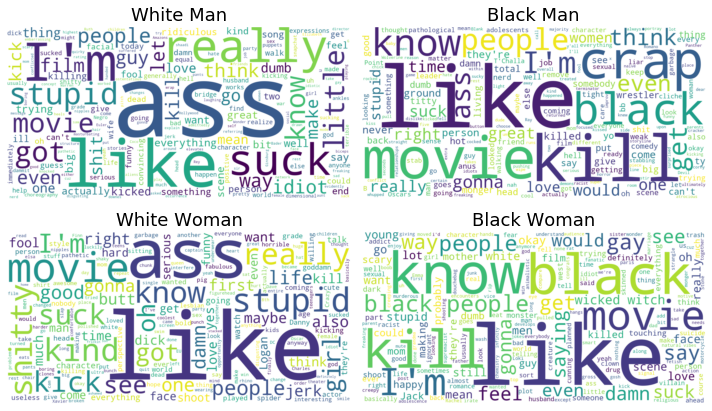

In [13]:
output_path = "../data/imgs"
fig, axs = plt.subplots(2, 2, figsize=(10,6))

for i, (group, content) in enumerate(group_to_content.items()):
    wordcloud = WordCloud(
        stopwords=stopwords.words("english"),
        background_color="white",
        width=1600, height=800
    ).generate(content)

    axs[i//2, i%2].imshow(wordcloud, interpolation='bilinear')
    axs[i//2, i%2].set_title(f"{group}")
    axs[i//2, i%2].set_axis_off()

plt.tight_layout()
plt.savefig(os.path.join(output_path, "wordclouds.pdf"))
plt.show()

---

In [14]:
group_to_content = {}
curse_words = json.load(open("../data/bad_words_scored.json"))
curse_words = [key for key, value in curse_words.items() if value > 0.2]

pwd = "../data/03_scored/with_curse_words"
df = pd.read_csv("../data/download_descriptions.csv")
for group in df.group.unique():
    dfs = []
    for _, row in df[df.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]

        try:
            dfs.append(pd.read_csv(os.path.join(pwd, video_id)))
        except:
            pass

    df_group = pd.concat(dfs)
    group_to_content[group] = ' '.join(df_group.text.values)
    
    del dfs

In [15]:
curse_words = open("../data/bad_words.txt").read().split()
n_curse_per_group = {}

for group, content in group_to_content.items():
    for word in content.split():
        if word in curse_words:
            n_curse_per_group[group] = n_curse_per_group.get(group, 0) + 1
    
    n_curse_per_group[group] = n_curse_per_group[group]/len(content.split())

In [16]:
sorted(n_curse_per_group.items(), key=lambda item: item[1])

[('White Woman', 0.005744350203149282),
 ('White Man', 0.005775209072201059),
 ('Black Man', 0.007927837073143401),
 ('Black Woman', 0.008387816935098071)]

---

### How many content producers are there?

In [40]:
content_creators = {}

pwd = "../data/03_scored/without_curse_words"
df = pd.read_csv("../data/download_descriptions.csv")
for group in df.group.unique():
    dfs = []
    for _, row in df[df.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]
        
        channel = row["url"].split("ab_channel=")[1]
        try:
            pd.read_csv(os.path.join(pwd, video_id))
            content_creators[group] = content_creators.get(group, []) + [channel]
        except:
            pass

In [41]:
for group, creators in content_creators.items():
    content_creators[group] = len(Counter(creators))

In [42]:
content_creators

{'White Man': 160, 'Black Man': 49, 'White Woman': 80, 'Black Woman': 27}

([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

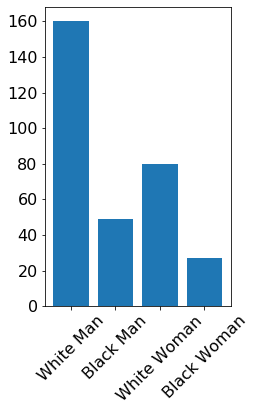

In [43]:
plt.bar(content_creators.keys(), content_creators.values())
plt.xticks(rotation=45)